In [1]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join as opj
from os.path import join, exists, split
import time
import urllib.request
import warnings
from pprint import pprint
import zipfile
import glob
warnings.filterwarnings('ignore')
from transformers import AutoFeatureExtractor, ClapModel
import torch
import torchaudio

from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


import pandas as pd
from nilearn import maskers
from nilearn import plotting
import tqdm

from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, mean_img
import matplotlib.pyplot as plt
import nilearn
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_contrast_matrix
from importlib import reload # python 2.7 does not require this
from data_agg import *
import pickle
# from nltools.data import Brain_Data, Adjacency
# from nltools.stats import align

import seaborn as sns
import IPython.display as ipd
from sklearn.metrics import confusion_matrix

from diffusers import MusicLDMPipeline, AudioPipelineOutput, StableAudioPipeline
# from diffusers import DiffusionPipeline, AudioPipelineOutput
from IPython.display import Audio


os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
from data.audioLDM_pre import *
from transformers import AutoFeatureExtractor, ClapModel, ClapProcessor

repo_id = "ucsd-reach/musicldm"
musicldm_pipe = MusicLDMPipeline.from_pretrained(repo_id, torch_dtype=torch.float32)
device = "cuda:6" if torch.cuda.is_available() else "cpu"
musicldm_pipe = musicldm_pipe.to(device)

clap_model_id="laion/larger_clap_music_and_speech"
model = ClapModel.from_pretrained(clap_model_id).to(device)
processor = ClapProcessor.from_pretrained(clap_model_id)
feature_extractor = AutoFeatureExtractor.from_pretrained(clap_model_id)


orig_freq = 44100
sampling_rate_ldm = 16000
n_mel_channels = 64
mel_fmin = 0
mel_fmax = 8000
filter_length = 1024
hop_length = 160
win_length = 1024 
window = 'hann'
target_length = int(duration * sampling_rate_ldm / hop_length)
pad_wav_start_sample = 0


stft = STFT(
    filter_length=filter_length, 
    hop_length=hop_length, 
    win_length=win_length,
    window=window
)

def get_mel_features(audio):
    magnitude, phase = stft.transform(audio)
    mel_basis = librosa_mel_fn(
                sr=sampling_rate_ldm, n_fft=filter_length, n_mels=n_mel_channels, fmin=mel_fmin, fmax=mel_fmax
            )
    mel_basis = torch.from_numpy(mel_basis).float()
    magnitudes = magnitude.data
    mel_output = torch.matmul(mel_basis, magnitudes)
    mel_output = spectral_normalize(mel_output, torch.log).permute(0,2,1)

    return mel_output




Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]


In [3]:
def get_latents_from_vae(pipe, audio):

    audio_feat = get_mel_features(audio).to(device).unsqueeze(1)
    with torch.no_grad():
        # audio = torch.cat((audio.unsqueeze(0), audio.unsqueeze(0)), dim=1)    # questo per stable audio
        # encoded = pipe.vae.encode(audio.half())
        encoded = pipe.vae.encode(audio_feat)
        latents_val = pipe.vae.config.scaling_factor * encoded.latent_dist.sample()
        # latents_val = encoded.latent_dist.sample()

    return latents_val.cpu()

In [4]:
with open('/srv/nfs-data/sisko/matteoc/music/working_data_dict_vaeLdm' + '.pkl', 'rb') as file_to_read:
    working_data_dict = pickle.load(file_to_read)

In [5]:
def load_transformed_data(data_folder):
    # Initialize an empty dictionary to store the data
    loaded_data_dict = {}

    # Loop through all files in the data folder
    for filename in os.listdir(data_folder):
        # Construct the full path of the file
        file_path = os.path.join(data_folder, filename)
        
        # Extract the subject ID and key from the filename
        # Assuming filenames are in the format 'sub_key.ext'
        sub, key = filename.split('_', 1)
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key
        
        #repeat
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key

        # Initialize sub dictionary if it doesn't exist
        if sub not in loaded_data_dict:
            loaded_data_dict[sub] = {}

        # Determine the file type and load accordingly
        if filename.endswith('.npy'):
            loaded_data_dict[sub][key] = np.load(file_path)
        elif filename.endswith('.pkl'):
            with open(file_path, 'rb') as file:
                loaded_data_dict[sub][key] = pickle.load(file)

        print(f"Loaded {key} from {file_path}")

    return loaded_data_dict



In [6]:
transform_masking=True
subject_ids = ["sub-001", "sub-002", "sub-003", "sub-004", "sub-005"]

mask_path = "mask_to_save/mask_him_005.nii.gz"
# mask_path = "mask_01.nii.gz"
if transform_masking:
    base_masker=working_data_dict["sub-001"]["masker"]
    selected_indices=base_masker.transform(nib.load(mask_path))
    for sub in subject_ids:
        working_data_dict[sub]["train_fmri_avg"]=working_data_dict[sub]["train_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
        working_data_dict[sub]["test_fmri_avg"]=working_data_dict[sub]["test_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
       
if transform_masking:
    # Ensure the data directory exists
    data_folder = 'data'
    os.makedirs(data_folder, exist_ok=True)

    # Assuming working_data_dict is your main dictionary and 'sub' is defined
    for sub in subject_ids:
        for key, value in working_data_dict[sub].items():
            # Convert the value to a numpy array if it's not already one 
            print(key)

            # Define the path for the output file
            file_path = os.path.join(data_folder, f'{sub}_{key}.npy')

            # Check if the value is a numpy array
            if isinstance(value, np.ndarray):
                # Save the numpy array to a file with .npy extension
                np.save(file_path + '.npy', value)
                print(f"Saved {key} as an array to {file_path}.npy")
            else:
                # Save other types of data using pickle with .pkl extension
                with open(file_path + '.pkl', 'wb') as file:
                    pickle.dump(value, file, protocol=pickle.HIGHEST_PROTOCOL)
                print(f"Saved {key} using pickle to {file_path}.pkl")

            print(f"Saved {key} to {file_path}")      

else:
    # Use the function
    data_folder = 'data'  # Specify the data folder path
    working_data_dict = load_transformed_data(data_folder)




train_fmri
Saved train_fmri using pickle to data/sub-001_train_fmri.npy.pkl
Saved train_fmri to data/sub-001_train_fmri.npy
train_audio_feat
Saved train_audio_feat using pickle to data/sub-001_train_audio_feat.npy.pkl
Saved train_audio_feat to data/sub-001_train_audio_feat.npy
train_genre
Saved train_genre using pickle to data/sub-001_train_genre.npy.pkl
Saved train_genre to data/sub-001_train_genre.npy
train_audio
Saved train_audio using pickle to data/sub-001_train_audio.npy.pkl
Saved train_audio to data/sub-001_train_audio.npy
test_fmri
Saved test_fmri using pickle to data/sub-001_test_fmri.npy.pkl
Saved test_fmri to data/sub-001_test_fmri.npy
test_audio_feat
Saved test_audio_feat using pickle to data/sub-001_test_audio_feat.npy.pkl
Saved test_audio_feat to data/sub-001_test_audio_feat.npy
test_genre
Saved test_genre using pickle to data/sub-001_test_genre.npy.pkl
Saved test_genre to data/sub-001_test_genre.npy
test_audio
Saved test_audio using pickle to data/sub-001_test_audio.npy.

In [7]:
df_captions = pd.read_csv('/srv/nfs-data/sisko/matteoc/music' + '/brain2music-captions.csv')
print(df_captions.head())
captions_array = df_captions.to_numpy()
caption_dict = {item[0].split('_')[0]: item[1] for item in captions_array}

for subj in subject_ids:

    train_stim_name_list = working_data_dict[subj]['train_stim_name']
    train_stim_caption_list = []

    for file_path in train_stim_name_list:
        genre_number = file_path.split('/')[-1].replace('.wav', '')
        caption = caption_dict.get(genre_number, "Caption not found")
        train_stim_caption_list.append(caption)

    working_data_dict[subj]['train_stim_caption'] = train_stim_caption_list


for subj in subject_ids:

    test_stim_name_list = working_data_dict[subj]['test_stim_name']
    test_stim_caption_list = []

    for file_path in test_stim_name_list:
        genre_number = file_path.split('/')[-1].replace('.wav', '')
        caption = caption_dict.get(genre_number, "Caption not found")
        test_stim_caption_list.append(caption)

    working_data_dict[subj]['test_stim_caption'] = test_stim_caption_list


                ID                                             DescEN
0  blues.00000_15s  Heavy blues with male vocals. Simple cutting w...
1  blues.00002_15s  Rhythmic blues. Obligatory trumpet obbligato a...
2  blues.00005_15s  Slow blues musical piece. Sentimental atmosphe...
3  blues.00006_15s  This blues is played with twin guitars only. T...
4  blues.00010_15s  This is an instrumental piece with electric gu...


In [8]:
import pandas as pd

def process_data(data_dict, key_suffix, features_key, genre_key, stim_name_key, fmri_key, 
                 stim_caption_key, feat_vae_key, audio_raw_key):
    # Create DataFrame for fMRI and stimulus names
    df = pd.DataFrame(data_dict[fmri_key], dtype=float)
    df['Stimulus'] = data_dict[stim_name_key]
    # Group by 'Caption' and calculate the mean for fMRI data
    fmri_avg = df.groupby('Stimulus').mean().reset_index()
    
    # Create DataFrame for audio features and stimulus names
    df_features = pd.DataFrame(data_dict[features_key], dtype=float)
    df_features['Stimulus'] = data_dict[stim_name_key]
    features_avg = df_features.groupby('Stimulus').mean().reset_index()

    df_audio_raw = pd.DataFrame(data_dict[audio_raw_key], columns=['RawAudio'])
    df_audio_raw['Stimulus'] = data_dict[stim_name_key]
    audio_raw_avg = df_audio_raw.groupby('Stimulus').first().reset_index()
    
    # Handle genres (assuming genre data is aligned with stimuli names)
    df_genre = pd.DataFrame(data_dict[genre_key], columns=['Genre'])
    df_genre['Stimulus'] = data_dict[stim_name_key] 
    # Since genre should be consistent for the same caption, we can take the first occurrence
    genre_avg = df_genre.groupby('Stimulus').first().reset_index()

    # Handle genres (assuming genre data is aligned with stimuli names)
    df_caption = pd.DataFrame(data_dict[stim_caption_key], columns=['Caption'])
    df_caption['Stimulus'] = data_dict[stim_name_key]
    caption_avg = df_caption.groupby('Stimulus').first().reset_index()

    df_vae = pd.DataFrame(data_dict[feat_vae_key].reshape(data_dict[feat_vae_key].shape[0],-1), dtype=float)
    df_vae['Stimulus'] = data_dict[stim_name_key]
    vae_avg = df_vae.groupby('Stimulus').mean().reset_index()
    
    return {
        key_suffix + '_audio_feat': features_avg.drop(columns='Stimulus').values,
        key_suffix + '_genre': genre_avg['Genre'].values,
        key_suffix + '_stim_name_avg': fmri_avg['Stimulus'].values,
        key_suffix + '_caption_avg': caption_avg['Caption'].values,
        key_suffix + '_fmri_avg': fmri_avg.drop(columns='Stimulus').values,
        key_suffix + '_vae_avg': vae_avg.drop(columns='Stimulus').values,
        key_suffix + '_audio_raw_avg': audio_raw_avg['RawAudio'].values 
    }


working_data_dict_avg = {}
for sub in subject_ids:
    working_data_dict_avg[sub] = {}

    # Process training data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'train',
            'train_audio_feat',
            'train_genre',
            'train_stim_name',
            'train_fmri_avg',
            'train_stim_caption',
            'train_audio_vae', 
            'train_audio'
        )
    )

    # Process testing data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'test',
            'test_audio_feat',
            'test_genre',
            'test_stim_name',
            'test_fmri_avg',
            'test_stim_caption',
            'test_audio_vae', 
            'test_audio'
        )
    )



In [9]:
# STRONGER FUNCTIONAL ALIGNMENT

target_sub="sub-001"

# X_train_aligned = [working_data_dict_avg[source_sub]["train_fmri_avg"]]
# X_test_aligned  = [working_data_dict_avg[source_sub]["test_fmri_avg"]]
X_train_aligned = []
X_test_aligned  = []


for source_sub in subject_ids:

    print(source_sub)
    source_train=working_data_dict_avg[source_sub]["train_fmri_avg"]
    target_train=working_data_dict_avg[target_sub]["train_fmri_avg"]

    source_test=working_data_dict_avg[source_sub]["test_fmri_avg"]
    target_test=working_data_dict_avg[target_sub]["test_fmri_avg"]

    
    aligner=RidgeCV(alphas=[1e2,1e3,1e4,5e4], fit_intercept=True)
    aligner.fit(source_train,target_train)

    aligned_source_test=aligner.predict(source_test)
    aligned_source_train=aligner.predict(source_train)

    aligned_source_train_adj = (aligned_source_train - aligned_source_train.mean(0)) / (1e-8 + aligned_source_train.std(0))
    aligned_source_train_adj = target_train.std(0) * aligned_source_train_adj + target_train.mean(0)

    # Align and adjust source_test dataset
    aligned_source_test_adj = (aligned_source_test - aligned_source_test.mean(0)) / (1e-8 + aligned_source_test.std(0))
    aligned_source_test_adj = target_train.std(0) * aligned_source_test_adj + target_train.mean(0)
    
    X_train_aligned.append(aligned_source_train_adj)
    X_test_aligned.append(aligned_source_test_adj)
    
#concatenate all

X_train_aligned = np.concatenate(X_train_aligned,0)
X_test_aligned = np.concatenate(X_test_aligned,0)

#concatenate all the other keys

train_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["train_audio_feat"] for sub in subject_ids],0)
test_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["test_audio_feat"] for sub in subject_ids],0)

train_genre_aligned = np.concatenate([working_data_dict_avg[sub]["train_genre"] for sub in subject_ids],0)
test_genre_aligned = np.concatenate([working_data_dict_avg[sub]["test_genre"] for sub in subject_ids],0)

train_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_stim_name_avg"] for sub in subject_ids],0)
test_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_stim_name_avg"] for sub in subject_ids],0)

train_caption_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_caption_avg"] for sub in subject_ids],0)
test_caption_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_caption_avg"] for sub in subject_ids],0)

train_vae_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_vae_avg"] for sub in subject_ids],0)
test_vae_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_vae_avg"] for sub in subject_ids],0)

train_raw_audio_aligned = np.concatenate([working_data_dict_avg[sub]["train_audio_raw_avg"] for sub in subject_ids],0)
test_raw_audio_aligned = np.concatenate([working_data_dict_avg[sub]["test_audio_raw_avg"] for sub in subject_ids],0)


sub-001
sub-002
sub-003
sub-004
sub-005


In [10]:
import torch
import numpy as np
import torch.nn.functional as F

def uniforma_a_matrice_con_padding(array_di_tensori):
    """
    Converte un array numpy di tensori [1, N_i] in una matrice torch [M, max_len]
    con padding a destra (0) fino alla lunghezza massima.
    """
    # Step 1: Squeeze per rimuovere la dimensione extra [1, N] → [N]
    tensori = [t.squeeze(0) for t in array_di_tensori]
    # Step 2: Trova lunghezza massima
    max_len = max(t.shape[0] for t in tensori)
    # Step 3: Prealloca tensore finale con zeri
    M = len(tensori)
    matrice = torch.zeros((M, max_len), dtype=tensori[0].dtype)
    # Step 4: Copia i valori nei posti giusti
    for i, t in tqdm.tqdm(enumerate(tensori)):
        matrice[i, :t.shape[0]] = t

    return matrice


In [11]:
train_raw_audio_aligned = uniforma_a_matrice_con_padding(train_raw_audio_aligned)
test_raw_audio_aligned = uniforma_a_matrice_con_padding(test_raw_audio_aligned)

2400it [00:25, 94.48it/s] 
300it [00:03, 90.27it/s]


In [12]:
train_raw_audio_aligned.shape, test_raw_audio_aligned.shape

(torch.Size([2400, 675808]), torch.Size([300, 675808]))

In [13]:
X_train_aligned.shape, train_vae_avg_aligned.shape

((2400, 3043), (2400, 96000))

## Brain-Mapping to VAE Latents

In [34]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F


class MlpAvgTime(pl.LightningModule):
    def __init__(self, 
                 input_dim=1024, 
                 output_dim=512, 
                 lr=1e-3, 
                 tau=0.05,
                 loss_type="contrastive", 
                 projector_type="linear" 
                ):
        super().__init__()

        self.save_hyperparameters()

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 768),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(768, output_dim)
        )

        self.linear = nn.Sequential(
            nn.Linear(input_dim, output_dim)
        )

        self.loss_mse = nn.MSELoss()
        self.lr = lr
        self.tau = tau
        self.loss_type = loss_type
        self.projector_type = projector_type
        self.log_tau = nn.Parameter(torch.tensor(np.log(tau), dtype=torch.float32))

    def forward(self, x):  # shape: (batch, 200, 1024)
        if self.projector_type == "mlp":
            return self.mlp(x)
        else:
            return self.linear(x)

    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        if self.loss_type == "mse":
            loss = self.loss_mse(output, y)
        else:
            cos_matrix = self.cosine_similarity_matrix(output, y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)

        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        output = self(x)
        if self.loss_type == "mse":
            loss = self.loss_mse(output, y)
        else:
            cos_matrix = self.cosine_similarity_matrix(output, y)
            loss = self.contrastive_loss_nt(cos_matrix, self.tau)

        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)

In [14]:
from himalaya.ridge import RidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train=X_train_aligned.copy()
y_train=train_vae_avg_aligned.copy()
X_val=X_test_aligned.copy()
y_val=test_vae_avg_aligned.copy()
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42, shuffle=True)

# scaler_X = StandardScaler()
# scaler_y = StandardScaler()

# X_train = scaler_X.fit_transform(X_train)
# y_train = scaler_y.fit_transform(y_train)
# X_val = scaler_X.transform(X_val)
# y_val = scaler_y.transform(y_val)

device_id = 2  # Change this to your desired GPU index
torch.cuda.set_device(device_id)  # Set the current device

backend = set_backend("torch_cuda")
X_train = backend.asarray(X_train).to(f'cuda:{device_id}')
y_train = backend.asarray(y_train).to(f'cuda:{device_id}')

X_val = backend.asarray(X_val).to(f'cuda:{device_id}')
y_val = backend.asarray(y_val).to(f'cuda:{device_id}')

vm=RidgeCV(alphas=[0.1,1,10,1e2,1e3,1e4,5*1e4])
vm.fit(X_train,y_train)
predict=vm.predict(X_val)
# predict=scaler_y.inverse_transform(predict)
voxels_scores=vm.score(X_val,y_val)
test_vae_avg_align_pred=predict.reshape(X_val.shape[0], 8, 750, 16)
y_val = y_val.reshape(y_val.shape[0], 8, 750, 16)

In [15]:
y_val.mean(), y_val.std()

(tensor(-0.1106, device='cuda:2', dtype=torch.float64),
 tensor(1.0201, device='cuda:2', dtype=torch.float64))

In [16]:
test_vae_avg_align_pred.mean(), test_vae_avg_align_pred.std()

(tensor(-0.0995, dtype=torch.float64), tensor(1.6001, dtype=torch.float64))

In [17]:
test_vae_avg_align_pred = torch.tensor(test_vae_avg_align_pred).cpu()

In [18]:
sample_test = 0

with torch.no_grad():
    mel_spectrogram_pred = musicldm_pipe.vae.decode(test_vae_avg_align_pred[sample_test].unsqueeze(0).to(device).float()/musicldm_pipe.vae.config.scaling_factor).sample
    mel_spectrogram_true = musicldm_pipe.vae.decode(y_val[sample_test].unsqueeze(0).to(device).float()/musicldm_pipe.vae.config.scaling_factor).sample
    print('mel_spectrogram_pred: ', mel_spectrogram_pred.shape)

mel_spectrogram_pred:  torch.Size([1, 1, 3000, 64])


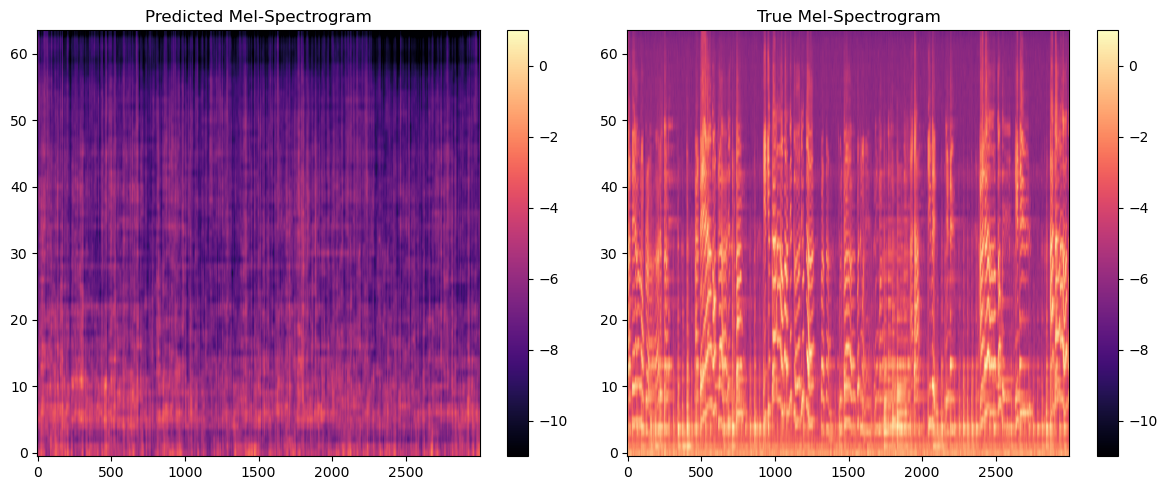

In [23]:
import torch
import matplotlib.pyplot as plt

mel_pred = mel_spectrogram_pred.squeeze().cpu().numpy().transpose(1, 0)
mel_true = mel_spectrogram_true.squeeze().cpu().numpy().transpose(1, 0)

plt.figure(figsize=(12, 5))
vmin = -11
vmax = 1

plt.subplot(1, 2, 1)
plt.imshow(mel_pred, aspect='auto', origin='lower', cmap='magma', vmin=vmin, vmax=vmax)
plt.title('Predicted Mel-Spectrogram')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(mel_true, aspect='auto', origin='lower', cmap='magma', vmin=vmin, vmax=vmax)
plt.title('True Mel-Spectrogram')
plt.colorbar()

plt.tight_layout()
plt.show()


In [24]:
from skimage.metrics import structural_similarity as ssim

# Normalizza tra 0 e 1
mel_pred_norm = (mel_pred - mel_pred.min()) / (mel_pred.max() - mel_pred.min())
mel_true_norm = (mel_true - mel_true.min()) / (mel_true.max() - mel_true.min())

ssim_value = ssim(mel_pred_norm, mel_true_norm, data_range=1.0)

print(f'SSIM: {ssim_value:.4f}')


SSIM: 0.1355


## Extracting Audio-Time Feature

In [14]:
audio_np = train_raw_audio_aligned.numpy()

In [15]:
import librosa

sr = 22050  

# Stima del tempo (BPM)
tempo, beats = librosa.beat.beat_track(y=audio_np[0], sr=sr)
print(f"BPM stimato: {tempo}")


BPM stimato: 123.046875


In [16]:
onset_env = librosa.onset.onset_strength(y=audio_np[0], sr=sr)
onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
print(f"Onset times: {onset_times}")


Onset times: [ 0.06965986  0.13931973  0.2554195   0.58049887  0.71981859  1.04489796
  1.34675737  1.57895692  1.67183673  2.18267574  2.5077551   2.62385488
  2.9721542   3.13469388  3.59909297  3.9938322   4.10993197  4.41179138
  4.57433107  4.92263039  5.06195011  5.24770975  5.38702948  5.52634921
  5.89786848  6.01396825  6.36226757  6.5015873   6.84988662  6.98920635
  7.33750567  7.4768254   7.66258503  7.77868481  8.28952381  8.40562358
  8.77714286  8.91646259  9.218322    9.38086168  9.68272109  9.86848073
 10.14712018 10.35609977 10.63473923 10.68117914 11.19201814 11.30811791
 11.63319728 11.67963719 11.79573696 12.12081633 12.28335601 12.60843537
 12.7477551  13.23537415 13.56045351 13.7229932  14.00163265 14.07129252
 14.21061224 14.4892517  14.69823129 15.02331066 15.16263039 15.32517007
 15.4644898  15.62702948 15.76634921 15.90566893 16.06820862 16.37006803
 16.53260771 16.85768707 17.02022676 17.36852608 17.5078458  17.87936508
 17.9722449  18.29732426 18.80816327 1

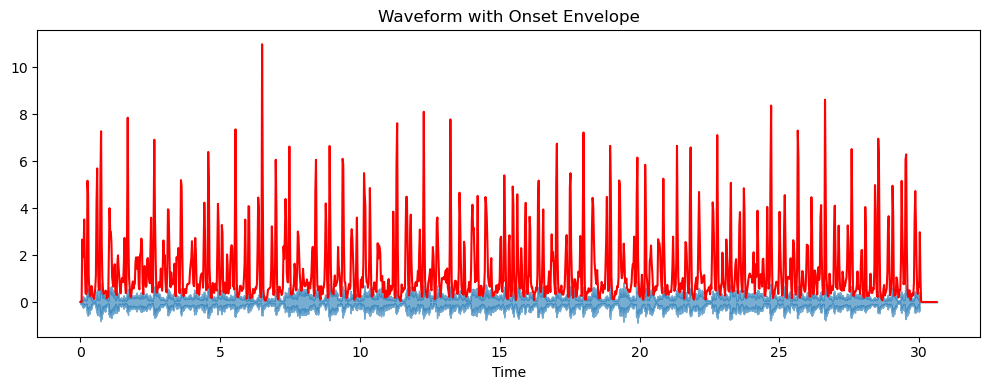

In [63]:
import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio_np[0], sr=sr, alpha=0.6)
plt.title('Waveform with Onset Envelope')
plt.plot(librosa.times_like(onset_env), onset_env, color='r')
plt.tight_layout()
plt.show()


In [64]:
beat_times = librosa.frames_to_time(beats, sr=sr)
print(f"Beat times: {beat_times}")


Beat times: [ 0.2554195   0.74303855  1.2306576   1.69505669  2.18267574  2.64707483
  3.13469388  3.62231293  4.10993197  4.57433107  5.06195011  5.54956916
  6.03718821  6.5015873   6.98920635  7.4768254   7.96444444  8.42884354
  8.91646259  9.40408163  9.89170068 10.35609977 10.84371882 11.33133787
 11.81895692 12.28335601 12.77097506 13.23537415 13.7229932  14.21061224
 14.69823129 15.16263039 15.62702948 16.09142857 16.55582766 17.04344671
 17.53106576 17.99546485 18.4830839  18.94748299 19.43510204 19.92272109
 20.38712018 20.85151927 21.33913832 21.82675737 22.29115646 22.77877551
 23.26639456 23.73079365 24.2184127  24.70603175 25.19365079 25.65804989
 26.14566893 26.63328798 27.12090703 27.58530612 28.07292517 28.56054422
 29.04816327 29.53578231]


In [317]:
import torch
import numpy as np
import librosa

def extract_temporal_features(audio_tensor, sr=22050):
    audio_np = audio_tensor.numpy()
    
    tempo, beats = librosa.beat.beat_track(y=audio_np, sr=sr)
    onset_env = librosa.onset.onset_strength(y=audio_np, sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    beat_times = librosa.frames_to_time(beats, sr=sr)
    
    # Aggregazioni statistiche (per  dimensione fissa)
    features = np.array([
        tempo,                                 # BPM
        len(beats),                            # Numero di beat
        len(onset_times),                      # Numero di onset
        np.mean(onset_env),                    # Media envelope
        np.std(onset_env),                     # Deviazione standard
        np.median(np.diff(onset_times)) if len(onset_times) > 1 else 0,  # Tempo medio tra onset
    ]).reshape(1, -1)  # Shape (1, features)
    
    return features


def extract_temporal_features_full(audio_tensor, sr=22050, n_bins=5):
    """
    Estrae una rappresentazione a dimensione fissa di un segnale audio,
    combinando feature globali e descrittori temporali aggregati per finestre.

    Parametri:
    ----------
    audio_tensor : torch.Tensor
        Segnale audio monodimensionale (es. [num_samples]) da cui estrarre le feature.
    sr : int
        Frequenza di campionamento dell'audio (di default 22050 Hz).
    n_bins : int
        Numero di finestre temporali in cui suddividere le sequenze frame-wise.

    Output:
    -------
    np.ndarray di shape (1, 44)
        Vettore delle feature estratte: 4 globali + (4 descrittori × 2 statistiche × n_bins)
    """

    # Converte il tensore PyTorch in NumPy array
    audio_np = audio_tensor.numpy()

    # === Estrazione feature globali ritmiche ===
    # BPM stimato con algoritmo di beat tracking
    tempo, beats = librosa.beat.beat_track(y=audio_np, sr=sr)
    
    # Onset envelope: forza degli eventi temporali
    onset_env = librosa.onset.onset_strength(y=audio_np, sr=sr)

    # Frame in cui avvengono gli onset
    onset_frames = librosa.onset.onset_detect(onset_envelope=onset_env, sr=sr)

    # Conversione in secondi degli onset
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)

    # Feature globali (fisse)
    global_features = np.array([
        tempo,                                # Tempo (BPM)
        len(beats),                           # Numero totale di beat rilevati
        len(onset_times),                     # Numero totale di onset rilevati
        np.median(np.diff(onset_times)) if len(onset_times) > 1 else 0  # Tempo mediano tra onset
    ])

    # === Estrazione di feature frame-wise temporali ===
    features_to_bin = {
        "onset_env": onset_env,  # Intensità dei cambiamenti temporali (dinamica)
        "rms": librosa.feature.rms(y=audio_np, frame_length=2048, hop_length=512).flatten(),  # Energia del segnale
        "spec_centroid": librosa.feature.spectral_centroid(y=audio_np, sr=sr).flatten(),      # Centro di massa dello spettro
        "spec_bandwidth": librosa.feature.spectral_bandwidth(y=audio_np, sr=sr).flatten(),     # Larghezza spettrale
    }

    binned_features = []

    # Per ciascun descrittore, divide la sequenza in `n_bins` parti
    # e calcola media e deviazione standard per ogni finestra
    for key, seq in features_to_bin.items():
        bins = np.array_split(seq, n_bins)
        for b in bins:
            binned_features.append(np.mean(b))
            binned_features.append(np.std(b))

    # Concatenazione di tutte le feature
    all_features = np.concatenate([global_features, np.array(binned_features)]).reshape(1, -1)

    return all_features


In [318]:
train_tmp_features = [extract_temporal_features_full(audio) for audio in tqdm.tqdm(train_raw_audio_aligned)]
train_tmp_features = np.vstack(train_tmp_features)

test_tmp_features = [extract_temporal_features_full(audio) for audio in tqdm.tqdm(test_raw_audio_aligned)]
test_tmp_features = np.vstack(test_tmp_features)

100%|██████████| 300/300 [02:37<00:00,  1.90it/s]


In [375]:
# np.save('/srv/nfs-data/sisko/matteoc/music/train_tmp_features_full.npy', train_tmp_features)
# np.save('/srv/nfs-data/sisko/matteoc/music/test_tmp_features_full.npy', test_tmp_features)

train_tmp_features = np.load('/srv/nfs-data/sisko/matteoc/music/train_tmp_features.npy')
test_tmp_features = np.load('/srv/nfs-data/sisko/matteoc/music/test_tmp_features.npy')

In [376]:
train_tmp_features.shape

(2400, 6)

## Mapping to TMP Feat

In [ ]:
from himalaya.ridge import RidgeCV
from himalaya.kernel_ridge import KernelRidgeCV
from himalaya.backend import set_backend
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train=X_train_aligned.copy()
X_val=X_test_aligned.copy()

scaler = StandardScaler()
train_tmp_features_scaled = scaler.fit_transform(train_tmp_features)
test_tmp_features_scaled = scaler.transform(test_tmp_features)

y_train = torch.tensor(train_tmp_features_scaled).to('cuda:2')
y_val = torch.tensor(test_tmp_features_scaled).to('cuda:2')

device_id = 2  # Change this to your desired GPU index
torch.cuda.set_device(device_id)  # Set the current device

backend = set_backend("torch_cuda")
X_train = backend.asarray(X_train).to(f'cuda:{device_id}')
y_train = backend.asarray(y_train).to(f'cuda:{device_id}')

X_val = backend.asarray(X_val).to(f'cuda:{device_id}')
y_val = backend.asarray(y_val).to(f'cuda:{device_id}')

vm=RidgeCV(alphas=[0.1,1,10,20,1e2,1e3,1e4,5*1e4])
vm.fit(X_train,y_train)
predict=vm.predict(X_val)
voxels_scores=vm.score(X_val,y_val)

In [378]:
from scipy.stats import pearsonr

y_true = y_val.cpu().numpy()
y_pred = predict.cpu().numpy()

n_features = y_true.shape[1]
n_samples = y_true.shape[0]
correlations = []
p_values = []

for i in tqdm.tqdm(range(n_features)):
    r, p = pearsonr(y_true[:,i], y_pred[:,i])
    correlations.append(r)
    p_values.append(p)

correlations = np.array(correlations)
p_values = np.array(p_values)

100%|██████████| 6/6 [00:00<00:00, 2455.44it/s]


In [379]:
mean_corr = np.mean(correlations)
print(f"Mean Pearson correlation across samples: {mean_corr:.3f}")

Mean Pearson correlation across samples: 0.453


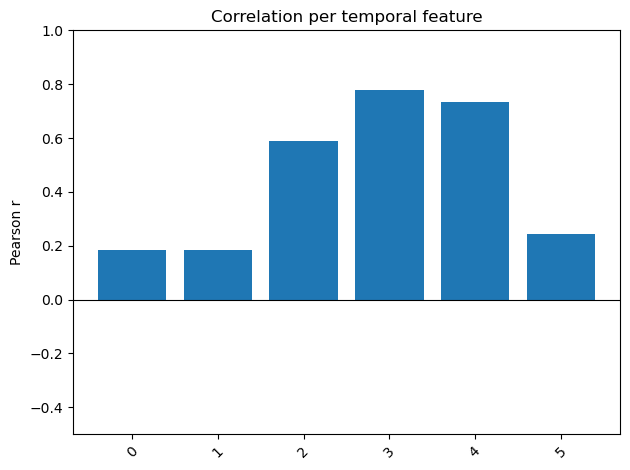

In [402]:
import matplotlib.pyplot as plt

plt.bar(range(len(correlations)), correlations)
plt.xticks(range(len(correlations)), np.arange(6), rotation=45)
plt.ylabel('Pearson r')
plt.title('Correlation per temporal feature')
plt.ylim(-0.5, 1)
plt.grid(False)
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


In [383]:
# np.corrcoef(y_true.T, y_pred.T)[0:n_features, n_features:]

In [384]:
from statsmodels.stats.multitest import multipletests

# FDR correction
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')


In [385]:
rejected

array([ True,  True,  True,  True,  True,  True])

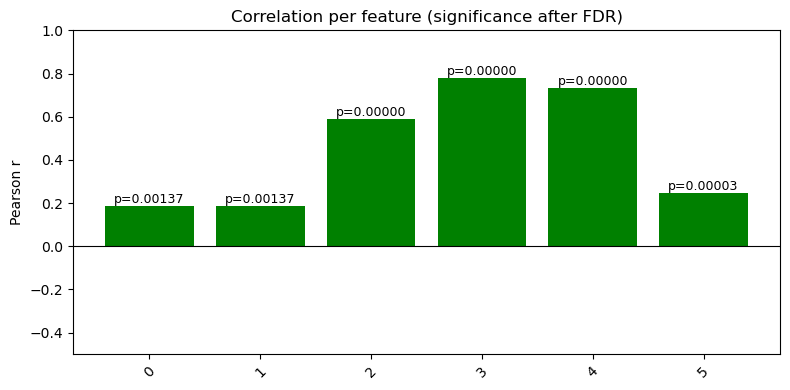

In [387]:
import matplotlib.pyplot as plt

feature_names = np.arange(6)

plt.figure(figsize=(8, 4))
bars = plt.bar(range(len(correlations)), correlations, color=['green' if sig else 'gray' for sig in rejected])
plt.xticks(range(len(correlations)), feature_names, rotation=45)
plt.ylabel("Pearson r")
plt.title("Correlation per feature (significance after FDR)")
plt.ylim(-0.5, 1)
plt.axhline(0, color='black', linewidth=0.8)

for i, (bar, pval) in enumerate(zip(bars, pvals_corrected)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"p={pval:.5f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [388]:
import pandas as pd

df_results = pd.DataFrame({
    'Feature': feature_names,
    'r': correlations,
    'raw_p': p_values,
    'p_FDR': pvals_corrected,
    'Significant (FDR)': rejected
})

print(df_results)


   Feature         r         raw_p         p_FDR  Significant (FDR)
0        0  0.183960  1.372686e-03  1.372686e-03               True
1        1  0.185294  1.264312e-03  1.372686e-03               True
2        2  0.590035  1.583929e-29  3.167857e-29               True
3        3  0.778470  3.153288e-62  1.891973e-61               True
4        4  0.734060  5.137550e-52  1.541265e-51               True
5        5  0.244477  1.852723e-05  2.779084e-05               True


## Permutation Test

In [389]:
from scipy.stats import pearsonr

feature_r = np.array([
    pearsonr(y_pred[:,i], y_val[:,i].cpu())[0]
    for i in range(y_val.shape[1])
])

sample_r = np.array([
    pearsonr(y_pred[i], y_val[i].cpu())[0]
    for i in range(y_val.shape[0])
])


In [390]:
n_permutations = 1000
perm_feature_r = np.zeros((n_permutations, y_val.shape[1]))
perm_sample_r = np.zeros((n_permutations, y_val.shape[0]))

for p in tqdm.tqdm(range(n_permutations)):
    idx_perm = np.random.permutation(y_val.shape[1])
    y_val_perm = y_val[:,idx_perm].cpu()
    for i in range(y_val.shape[1]):
        r, _ = pearsonr(y_pred[:,i], y_val_perm[:,i])
        perm_feature_r[p, i] = r


for p in tqdm.tqdm(range(n_permutations)):
    idx_perm = np.random.permutation(y_val.shape[0])
    y_val_perm = y_val[idx_perm].cpu()
    for i in range(y_val.shape[0]):
        r, _ = pearsonr(y_pred[i], y_val_perm[i])
        perm_sample_r[p, i] = r


100%|██████████| 1000/1000 [00:29<00:00, 34.31it/s]


In [391]:
n_subj = 5

perm_sample_r = perm_sample_r.reshape(1000, n_subj, -1)       
perm_sample_r = perm_sample_r.mean(axis=1)       

sample_r = sample_r.reshape(n_subj, -1)             
sample_r = sample_r.mean(axis=0) 

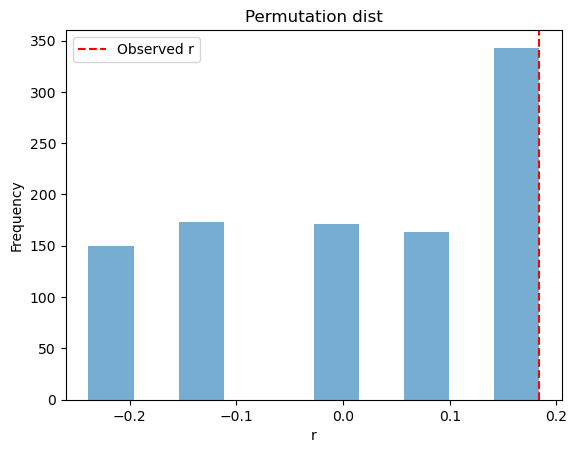

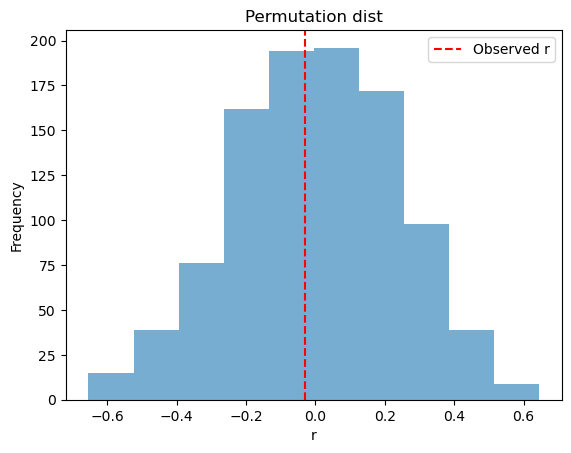

In [417]:
import matplotlib.pyplot as plt

n_sample = 53
n_feature = 0

plt.hist(perm_feature_r[:, n_feature], bins=10, alpha=0.6)
plt.axvline(feature_r[n_feature], color='red', linestyle='--', label='Observed r')
plt.title(f'Permutation dist')
plt.xlabel('r')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(perm_sample_r[:, n_sample], bins=10, alpha=0.6)
plt.axvline(sample_r[n_sample], color='red', linestyle='--', label='Observed r')
plt.title(f'Permutation dist')
plt.xlabel('r')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [416]:
np.mean(perm_sample_r[:, n_sample]), sample_r[n_sample]

(0.02553120262999157, -0.03953522196906516)

In [411]:
from scipy import stats

pval_stats = []
for sample in tqdm.tqdm(range(sample_r.shape[0])):                 
    t_stat, p_value = stats.ttest_1samp(perm_sample_r[:, sample], popmean=sample_r[sample], alternative='less')
    pval_stats.append(p_value)

100%|██████████| 60/60 [00:00<00:00, 5451.87it/s]


In [412]:
rejected, pvals_corr, _, _ = multipletests(pval_stats, alpha=0.05, method='fdr_bh')

In [413]:
rejected

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
        True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False,  True,  True,  True,  True,  True])

In [414]:
pvals_corr.mean()

0.13333333333333372

## Ours vs Logistic Regression

In [518]:
from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge

# OUR DECODING

X_train=X_train_aligned.copy()
X_test=X_test_aligned.copy()

# brain_to_latent=RidgeCV(alphas=[0.1,1,10,20,40,1e2,1e3,1e4,5*1e4])
brain_to_latent=Ridge(alpha=40)
brain_to_latent.fit(X_train, train_audio_feat_aligned)

audio_feat_pred=brain_to_latent.predict(X_test)

In [534]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(test_audio_feat_aligned[:60])
distances, top_indices = nbrs.kneighbors(audio_feat_pred)
top_indices_subj = top_indices.reshape([5, 60, 3])

top1_our_decoding = []
top3_our_decoding = []
for sub_idx in range(5):
    count_top_1 = 0
    count_top_3 = 0
    for idx in range(60):
        genre_orig = test_genre_aligned[:60][idx]
        genre_decod_list = [genre_decod for genre_decod in test_genre_aligned[:60][top_indices_subj[sub_idx][idx]]]    
        if genre_orig == genre_decod_list[0]:
            count_top_1 = count_top_1 + 1
        if genre_orig in genre_decod_list:
            count_top_3 = count_top_3 + 1
    top1_our_decoding.append(count_top_1)
    top3_our_decoding.append(count_top_3)

print('count_top_1: ',np.array(top1_our_decoding).mean()/60)
print('count_top_3: ',np.array(top3_our_decoding).mean()/60)


count_top_1:  0.6133333333333333
count_top_3:  0.8033333333333333


In [486]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegressionCV

# LOGISTIC REGRESSION

le = LabelEncoder()

train_genre_enc = le.fit_transform(train_genre_aligned)
test_genre_enc = le.transform(test_genre_aligned)
X_train = X_train_aligned.copy()
X_test = X_test_aligned.copy()

# clf_genre = LogisticRegression(random_state=0, solver='liblinear').fit(X_train, train_genre_enc)
clf_genre = LogisticRegressionCV(Cs=[0.01,0.1,1,10,100], random_state=0).fit(X_train, train_genre_enc)
y_pred_genre = clf_genre.predict(X_test)

In [487]:
from sklearn.metrics import accuracy_score

acc_top1 = accuracy_score(test_genre_enc, y_pred_genre)
print(f'Top-1 Accuracy classificatore diretto: {acc_top1:.3f}')

Top-1 Accuracy classificatore diretto: 0.533


In [533]:
from sklearn.metrics import top_k_accuracy_score

probs = clf_genre.predict_proba(X_test)
acc_top3 = top_k_accuracy_score(test_genre_enc, probs, k=3)
print(f'Top-3 Accuracy classificatore diretto: {acc_top3:.3f}')

Top-3 Accuracy classificatore diretto: 0.807
